***Data Preprocessing***


In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import pickle

In [2]:
from tensorflow import keras
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from keras.applications import ImageDataGenerator
from keras_preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [3]:
# Define dataset path
DATASET_PATH = "data"  # Change this to your dataset folder


In [4]:
# Define categories (same as your folder names)
CATEGORIES = ["Blight", "Common_Rust", "Gray_Leaf_Spot", "Healthy"]



In [5]:
# Image size for CNNs like ResNet
IMG_SIZE = 224

In [6]:
# Store images and labels
data = []
labels = []


In [7]:
import os
print(os.listdir("data"))


['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']


In [8]:
# Load images from each category

for category in CATEGORIES:
    folder_path = os.path.join(DATASET_PATH, category)
    class_index = CATEGORIES.index(category)  # Assign a label (0,1,2,3)

    for img_name in tqdm(os.listdir(folder_path), desc=f"Processing {category}"):
        img_path = os.path.join(folder_path, img_name)
        try:
            # Read and resize image
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize
            
            # Normalize pixels (0 to 1 range)
            img = img / 255.0

            # Append to dataset
            data.append(img)
            labels.append(class_index)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")


Processing Healthy: 100%|██████████| 1162/1162 [00:09<00:00, 126.56it/s]


In [9]:
# Convert lists to numpy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [10]:
# Split into Train (70%), Validation (20%), and Test (10%)
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.3, stratify=labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, stratify=y_temp, random_state=42)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

Training samples: 2931
Validation samples: 842
Test samples: 415


In [11]:
# Data Augmentation for Training Data
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2]
)

In [12]:
# ✅ Save all data in a Pickle file
with open("data.pkl", "wb") as f:
    pickle.dump({
        "X_train": X_train, "y_train": y_train,
        "X_val": X_val, "y_val": y_val,
        "X_test": X_test, "y_test": y_test
    }, f)

print("✅ Preprocessing Completed & Data Saved in data.pkl!")

✅ Preprocessing Completed & Data Saved in data.pkl!


***Data model training***


In [13]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
    
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt


In [14]:
# Load data
with open("data.pkl", "rb") as f:
    data = pickle.load(f)
    
X_train, y_train = data["X_train"], data["y_train"]
X_val, y_val = data["X_val"], data["y_val"]
X_test, y_test = data["X_test"], data["y_test"]


In [15]:
# Load base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base

In [16]:
# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [17]:
# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint("best_model.h5", save_best_only=True),
    CSVLogger("training_log.csv")
]

In [18]:
# Train model
model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=callbacks)


Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.7806 - loss: 0.5823

92/92 ━━━━━━━━━━━━━━━━━━━━ 50s 501ms/step - accuracy: 0.7816 - loss: 0.5798 - val_accuracy: 0.9394 - val_loss: 0.1951
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 43s 468ms/step - accuracy: 0.9365 - loss: 0.1698 - val_accuracy: 0.9204 - val_loss: 0.2274
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 46s 500ms/step - accuracy: 0.9402 - loss: 0.1389 - val_accuracy: 0.9276 - val_loss: 0.1975
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9698 - loss: 0.0943

92/92 ━━━━━━━━━━━━━━━━━━━━ 44s 476ms/step - accuracy: 0.9697 - loss: 0.0943 - val_accuracy: 0.9311 - val_loss: 0.1848
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 44s 481ms/step - accuracy: 0.9820 - loss: 0.0627 - val_accuracy: 0.9192 - val_loss: 0.2177
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 42s 460ms/step - accuracy: 0.9779 - loss: 0.0646 - val_accuracy: 0.9442 - val_loss: 0.1910
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 44s 478ms/step - accuracy: 0.9897 - loss: 0.0399 - val_accuracy: 0.9418 - val_loss: 0.2228


In [19]:
# Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"✅ Test Accuracy: {test_acc:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 399ms/step - accuracy: 0.8988 - loss: 0.2490
✅ Test Accuracy: 0.9229


In [20]:
# Predict and show classification report
y_pred = model.predict(X_test).argmax(axis=1)
print(classification_report(y_test, y_pred, target_names=["Blight", "Common_Rust", "Gray_Leaf_Spot", "Healthy"]))

13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 466ms/step
                precision    recall  f1-score   support

        Blight       0.90      0.84      0.87       114
   Common_Rust       0.97      0.96      0.96       129
Gray_Leaf_Spot       0.76      0.84      0.80        57
       Healthy       0.98      1.00      0.99       115

      accuracy                           0.92       415
     macro avg       0.90      0.91      0.91       415
  weighted avg       0.92      0.92      0.92       415



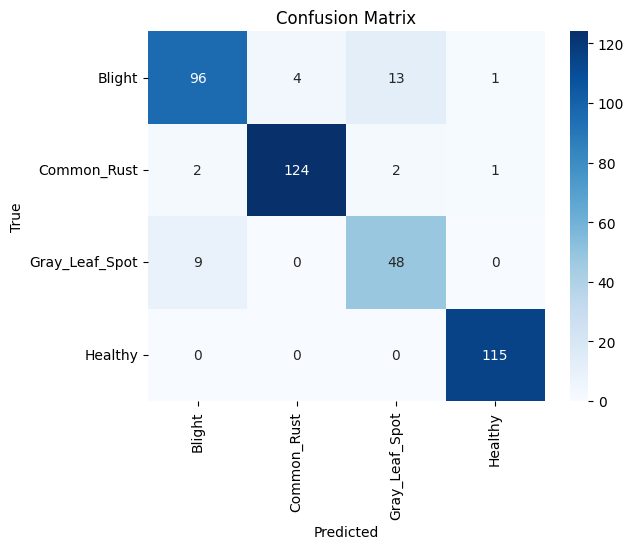

In [21]:
# Confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()